## Association Rules Market Basket Analysis

## Import Package

In [ ]:
# library
import pandas as pd
import matplotlib.pyplot as plt
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

## Load Data

ini tempat loading data

In [ ]:
# load data to dataframe
df = pd.read_excel('http://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


# Data Understanding

In [ ]:
# data profile
print('Data dimension (total row, total column) : {dim}' .format(dim=df.shape))
print('Count of unique invoice number : {count}' .format(count=df.InvoiceNo.nunique()))
print('Number of customer ID : {count}' .format(count=df.CustomerID.nunique()))

Data dimension (total row, total column) : (541909, 8)
Count of unique invoice number : 25900
Number of customer ID : 4372


In [ ]:
#number of 
df.isnull().sum(axis = 0)

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

# Data Preparation

In [ ]:
df['Description'] = df['Description'].str.strip()
df.dropna(axis=0, subset=['CustomerID'], inplace=True)
df['InvoiceNo'] = df['InvoiceNo'].astype('str')
df = df[~df['InvoiceNo'].str.contains('C')] # C is credit

In [ ]:
df['Country'].unique()

array(['United Kingdom', 'France', 'Australia', 'Netherlands', 'Germany',
       'Norway', 'EIRE', 'Switzerland', 'Spain', 'Poland', 'Portugal',
       'Italy', 'Belgium', 'Lithuania', 'Japan', 'Iceland',
       'Channel Islands', 'Denmark', 'Cyprus', 'Sweden', 'Finland',
       'Austria', 'Greece', 'Singapore', 'Lebanon',
       'United Arab Emirates', 'Israel', 'Saudi Arabia', 'Czech Republic',
       'Canada', 'Unspecified', 'Brazil', 'USA', 'European Community',
       'Bahrain', 'Malta', 'RSA'], dtype=object)

In [ ]:
basket = (df[df['Country'] =="France"]
          .groupby(['InvoiceNo', 'Description'])['Quantity']
          .sum().unstack().reset_index().fillna(0)
          .set_index('InvoiceNo'))

In [ ]:
basket

Description,10 COLOUR SPACEBOY PEN,12 COLOURED PARTY BALLOONS,12 EGG HOUSE PAINTED WOOD,12 MESSAGE CARDS WITH ENVELOPES,12 PENCIL SMALL TUBE WOODLAND,12 PENCILS SMALL TUBE RED RETROSPOT,12 PENCILS SMALL TUBE SKULL,12 PENCILS TALL TUBE POSY,12 PENCILS TALL TUBE RED RETROSPOT,12 PENCILS TALL TUBE WOODLAND,15CM CHRISTMAS GLASS BALL 20 LIGHTS,16 PIECE CUTLERY SET PANTRY DESIGN,18PC WOODEN CUTLERY SET DISPOSABLE,20 DOLLY PEGS RETROSPOT,200 RED + WHITE BENDY STRAWS,3 HOOK HANGER MAGIC GARDEN,3 PIECE SPACEBOY COOKIE CUTTER SET,3 RAFFIA RIBBONS 50'S CHRISTMAS,3 STRIPEY MICE FELTCRAFT,3 TIER CAKE TIN RED AND CREAM,3 TRADITIONAl BISCUIT CUTTERS SET,36 DOILIES DOLLY GIRL,36 DOILIES VINTAGE CHRISTMAS,36 FOIL HEART CAKE CASES,36 FOIL STAR CAKE CASES,36 PENCILS TUBE RED RETROSPOT,36 PENCILS TUBE SKULLS,36 PENCILS TUBE WOODLAND,3D HEARTS HONEYCOMB PAPER GARLAND,3D TRADITIONAL CHRISTMAS STICKERS,3D VINTAGE CHRISTMAS STICKERS,4 IVORY DINNER CANDLES SILVER FLOCK,4 PINK DINNER CANDLE SILVER FLOCK,4 TRADITIONAL SPINNING TOPS,5 HOOK HANGER MAGIC TOADSTOOL,5 HOOK HANGER RED MAGIC TOADSTOOL,50'S CHRISTMAS GIFT BAG LARGE,6 GIFT TAGS 50'S CHRISTMAS,6 GIFT TAGS VINTAGE CHRISTMAS,6 RIBBONS EMPIRE,...,WOODLAND CHARLOTTE BAG,WOODLAND DESIGN COTTON TOTE BAG,WOODLAND LARGE BLUE FELT HEART,WOODLAND LARGE PINK FELT HEART,WOODLAND LARGE RED FELT HEART,WOODLAND MINI BACKPACK,WOODLAND PARTY BAG + STICKER SET,WOODLAND SMALL BLUE FELT HEART,WOODLAND SMALL PINK FELT HEART,WOODLAND SMALL RED FELT HEART,WOODLAND STORAGE BOX LARGE,WOODLAND STORAGE BOX SMALL,WORLD WAR 2 GLIDERS ASSTD DESIGNS,WRAP VINTAGE DOILY,WRAP 50'S CHRISTMAS,WRAP ALPHABET DESIGN,WRAP CAROUSEL,WRAP CHRISTMAS VILLAGE,WRAP CIRCUS PARADE,WRAP DOILEY DESIGN,WRAP DOLLY GIRL,WRAP ENGLISH ROSE,WRAP GINGHAM ROSE,WRAP GREEN PEARS,WRAP I LOVE LONDON,WRAP PAISLEY PARK,WRAP PINK FAIRY CAKES,WRAP POPPIES DESIGN,WRAP RED APPLES,WRAP RED VINTAGE DOILY,WRAP SUKI AND FRIENDS,WRAP VINTAGE PETALS DESIGN,YELLOW COAT RACK PARIS FASHION,YELLOW GIANT GARDEN THERMOMETER,ZINC STAR T-LIGHT HOLDER,ZINC FOLKART SLEIGH BELLS,ZINC HERB GARDEN CONTAINER,ZINC METAL HEART DECORATION,ZINC T-LIGHT HOLDER STAR LARGE,ZINC T-LIGHT HOLDER STARS SMALL
InvoiceNo,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
536370,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536852,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536974,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
537065,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
537463,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,.

Quite a lot of zeros in the data but we also need to make sure any positive values are converted to a 1 and anything less the 0 is set to 0. so, let’s apply one hot encoding of the data and remove the postage column

In [ ]:
def encode_units(x):
    if x <= 0:
        return 0
    if x >= 1:
        return 1

basket_sets = basket.applymap(encode_units)

# we are not going to explore postage. 
basket_sets.drop('POSTAGE', inplace=True, axis=1)

In [ ]:
basket_sets

Description,10 COLOUR SPACEBOY PEN,12 COLOURED PARTY BALLOONS,12 EGG HOUSE PAINTED WOOD,12 MESSAGE CARDS WITH ENVELOPES,12 PENCIL SMALL TUBE WOODLAND,12 PENCILS SMALL TUBE RED RETROSPOT,12 PENCILS SMALL TUBE SKULL,12 PENCILS TALL TUBE POSY,12 PENCILS TALL TUBE RED RETROSPOT,12 PENCILS TALL TUBE WOODLAND,15CM CHRISTMAS GLASS BALL 20 LIGHTS,16 PIECE CUTLERY SET PANTRY DESIGN,18PC WOODEN CUTLERY SET DISPOSABLE,20 DOLLY PEGS RETROSPOT,200 RED + WHITE BENDY STRAWS,3 HOOK HANGER MAGIC GARDEN,3 PIECE SPACEBOY COOKIE CUTTER SET,3 RAFFIA RIBBONS 50'S CHRISTMAS,3 STRIPEY MICE FELTCRAFT,3 TIER CAKE TIN RED AND CREAM,3 TRADITIONAl BISCUIT CUTTERS SET,36 DOILIES DOLLY GIRL,36 DOILIES VINTAGE CHRISTMAS,36 FOIL HEART CAKE CASES,36 FOIL STAR CAKE CASES,36 PENCILS TUBE RED RETROSPOT,36 PENCILS TUBE SKULLS,36 PENCILS TUBE WOODLAND,3D HEARTS HONEYCOMB PAPER GARLAND,3D TRADITIONAL CHRISTMAS STICKERS,3D VINTAGE CHRISTMAS STICKERS,4 IVORY DINNER CANDLES SILVER FLOCK,4 PINK DINNER CANDLE SILVER FLOCK,4 TRADITIONAL SPINNING TOPS,5 HOOK HANGER MAGIC TOADSTOOL,5 HOOK HANGER RED MAGIC TOADSTOOL,50'S CHRISTMAS GIFT BAG LARGE,6 GIFT TAGS 50'S CHRISTMAS,6 GIFT TAGS VINTAGE CHRISTMAS,6 RIBBONS EMPIRE,...,WOODLAND CHARLOTTE BAG,WOODLAND DESIGN COTTON TOTE BAG,WOODLAND LARGE BLUE FELT HEART,WOODLAND LARGE PINK FELT HEART,WOODLAND LARGE RED FELT HEART,WOODLAND MINI BACKPACK,WOODLAND PARTY BAG + STICKER SET,WOODLAND SMALL BLUE FELT HEART,WOODLAND SMALL PINK FELT HEART,WOODLAND SMALL RED FELT HEART,WOODLAND STORAGE BOX LARGE,WOODLAND STORAGE BOX SMALL,WORLD WAR 2 GLIDERS ASSTD DESIGNS,WRAP VINTAGE DOILY,WRAP 50'S CHRISTMAS,WRAP ALPHABET DESIGN,WRAP CAROUSEL,WRAP CHRISTMAS VILLAGE,WRAP CIRCUS PARADE,WRAP DOILEY DESIGN,WRAP DOLLY GIRL,WRAP ENGLISH ROSE,WRAP GINGHAM ROSE,WRAP GREEN PEARS,WRAP I LOVE LONDON,WRAP PAISLEY PARK,WRAP PINK FAIRY CAKES,WRAP POPPIES DESIGN,WRAP RED APPLES,WRAP RED VINTAGE DOILY,WRAP SUKI AND FRIENDS,WRAP VINTAGE PETALS DESIGN,YELLOW COAT RACK PARIS FASHION,YELLOW GIANT GARDEN THERMOMETER,ZINC STAR T-LIGHT HOLDER,ZINC FOLKART SLEIGH BELLS,ZINC HERB GARDEN CONTAINER,ZINC METAL HEART DECORATION,ZINC T-LIGHT HOLDER STAR LARGE,ZINC T-LIGHT HOLDER STARS SMALL
InvoiceNo,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
536370,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
536852,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
536974,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
537065,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
537463,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
580986,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
581001,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
581171,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


# Modeling

In [ ]:
# set minimum support
frequent_itemsets = apriori(basket_sets, min_support=0.07, use_colnames=True)

In [ ]:
# list of rules
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)
rules.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(ALARM CLOCK BAKELIKE PINK),(ALARM CLOCK BAKELIKE GREEN),0.102828,0.097686,0.074550,0.725000,7.421711,0.064505,3.281140
1,(ALARM CLOCK BAKELIKE GREEN),(ALARM CLOCK BAKELIKE PINK),0.097686,0.102828,0.074550,0.763158,7.421711,0.064505,3.788061
2,(ALARM CLOCK BAKELIKE GREEN),(ALARM CLOCK BAKELIKE RED),0.097686,0.095116,0.079692,0.815789,8.576814,0.070400,4.912229
3,(ALARM CLOCK BAKELIKE RED),(ALARM CLOCK BAKELIKE GREEN),0.095116,0.097686,0.079692,0.837838,8.576814,0.070400,5.564267
4,(ALARM CLOCK BAKELIKE PINK),(ALARM CLOCK BAKELIKE RED),0.102828,0.095116,0.074550,0.725000,7.622297,0.064770,3.290488


In [ ]:
# total number of association rule
print('"number of association" {}'. format(rules.shape[0]))

"number of association" 26


Text(0.5, 1.0, 'Confidence')

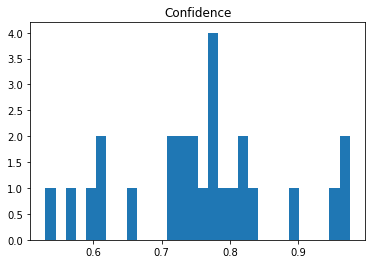

In [ ]:
# plot confidence results
rules.hist('confidence', grid =False, bins =30)
plt.title("Confidence")

Text(0.5, 1.0, 'Lift')

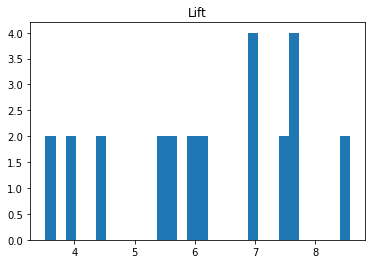

In [ ]:
# plot lift results
rules.hist('lift', grid =False, bins =30)
plt.title("Lift")

## Results

In [ ]:
# set minumum lift and confidence
rules[ (rules['lift'] >= 6) &
       (rules['confidence'] >= 0.8) ]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
2,(ALARM CLOCK BAKELIKE GREEN),(ALARM CLOCK BAKELIKE RED),0.097686,0.095116,0.079692,0.815789,8.576814,0.070400,4.912229
3,(ALARM CLOCK BAKELIKE RED),(ALARM CLOCK BAKELIKE GREEN),0.095116,0.097686,0.079692,0.837838,8.576814,0.070400,5.564267
18,(SET/6 RED SPOTTY PAPER CUPS),(SET/6 RED SPOTTY PAPER PLATES),0.138817,0.128535,0.123393,0.888889,6.915556,0.105550,7.843188
19,(SET/6 RED SPOTTY PAPER PLATES),(SET/6 RED SPOTTY PAPER CUPS),0.128535,0.138817,0.123393,0.960000,6.915556,0.105550,21.529563
20,"(SET/6 RED SPOTTY PAPER CUPS, SET/6 RED SPOTTY...",(SET/20 RED RETROSPOT PAPER NAPKINS),0.123393,0.133676,0.100257,0.812500,6.078125,0.083762,4.620394
21,"(SET/6 RED SPOTTY PAPER CUPS, SET/20 RED RETRO...",(SET/6 RED SPOTTY PAPER PLATES),0.102828,0.128535,0.100257,0.975000,7.585500,0.087040,34.858612
22,"(SET/6 RED SPOTTY PAPER PLATES, SET/20 RED RET...",(SET/6 RED SPOTTY PAPER CUPS),0.102828,0.138817,0.100257,0.975000,7.023611,0.085983,34.447301


## Check popularity of items

In [ ]:
basket['ALARM CLOCK BAKELIKE GREEN'].sum()

340.0

In [ ]:
basket['ALARM CLOCK BAKELIKE RED'].sum()

316.0